# Dataset

### O conjunto de dados analisados é contém o número de passageiros em vôos internacionais. 

### O dataset é composto por duas colunas, a primeira com datas (mês e ano) e a segunda o número de passageiros que voaram no período em milhares

### O dataset contém 144 entradas no período entre janeiro de 1949 e dezembro de 1960.

### Os dados foram obitidos em https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line


# Dynamic Linear Model

### Para fazer a predição usando DLM foi utilizado o código fornecido em sala de aula com parâmetros:

\begin{hmatrix}
G = np.array ([1,1,0,1]).reshape((2,2))
\end{hmatrix}
F = np.array([1, 0]).reshape((1,2))
W = np.diag([1e2, 1e1])
V = np.diag([1e2])
mo = np.array([1e2, 1e1]).reshape((2,1))
Co = np.diag([1e2, 1e2])

<font size=36px>Gaussian Process</font>



# Médias móveis

### Na estimativa por médias móveis consideramos a média das últimas $k$ amostras ($t-1, t-2, ..., t-k$) como a predição para o tempo t.

### Como as últimas 4 amostras estavam sendo considerados no processo gaussiano, decidimos também usar as últimas 4 amostras para as médias móveis


In [2]:
import numpy as np
import numpy.linalg as lin
import pandas as pd
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.preprocessing
import sklearn.cluster
import collections
import itertools
import datetime

%matplotlib inline

/home/thiago/anaconda3/lib/python3.6/site-packages/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Identity, NoneType, Kernel, InducingPoints], [Gaussian, Linear, NoneType, Sum, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
/home/thiago/anaconda3/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [3]:
def dlm(m0, C0, G, F, W, V, Y):
    T = Y.shape[1]
    
    m = m0
    C = C0
    
    m_list = np.zeros((T,m0.shape[0]))
    f_list = np.zeros(T)
    
    for t in range(T):
        
        y = Y[:,t]
        
        ##Parametros da priori de teta
        a = G.dot(m)
        R = G.dot(C).dot(G.T)+W
        
        ##Parametros da preditiva de y        
        f = F.dot(a)
        Q = F.dot(R).dot(F.T)+V
        
        ##Parametros da posteriori
        A_t = lin.solve(Q, F.dot(R))
        A = A_t.T
        
        m = a+A.dot(y-f)
        C = R-A.dot(Q).dot(A.T)
        
        m_list[t] = m.reshape(-1)
        f_list[t] = f
        
        
    return f_list, m_list

In [4]:
def lag_dataframe(d,i):
    if i == 0:
        return d
    else:
        return d.shift(i).rename(lambda c: f'{c}_lag{i}', axis='columns')

def NARXfy(lag,*data):
    return pd.concat([
        lag_dataframe(x,i) for x in data for i in range(0,lag+1)
    ], axis=1)
    
def plot(ax, t, mean, var=None, label=None, color='C0'):
    ax.plot(t, mean, color=color, lw=2, label=label)
    if (var is not None):
        ax.fill_between(t, mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color=color, alpha=0.2)

In [5]:
data = pd.read_csv("international-airline-passengers.csv")
data['Month'] = pd.to_datetime(data['Month'])    ##Convert string to type datetime
data = data.sort_values('Month')
data = data.set_index('Month')
data['passengers in thousands'] = data['passengers in thousands'].astype(float)

# DATA
t = data.index
Y = data

In [5]:
lag = 5
train_size = 12*4

X = NARXfy(lag,Y)
X_train = X.iloc[lag:train_size].values
y_train = Y.iloc[lag+1:train_size+1].values

tf.logging.set_verbosity(tf.logging.ERROR)
meanf = gpflow.mean_functions.Linear(np.random.rand(X.shape[1],1), 0.0)
kern = gpflow.kernels.Periodic(X.shape[1])
GPNarx = gpflow.models.GPR(X_train, y_train, kern, meanf)
gpflow.train.ScipyOptimizer().minimize(GPNarx)
tf.logging.set_verbosity(tf.logging.INFO)

gp_y = GPNarx.predict_y(X)
gp_f = GPNarx.predict_f(X)

In [6]:
G = np.array ([1,1,0,1]).reshape((2,2))
F = np.array([1, 0]).reshape((1,2))
W = np.diag([1e2, 1e1])
V = np.diag([1e2])
mo = np.array([1e2, 1e1]).reshape((2,1))
Co = np.diag([1e2, 1e2])

dlm_y, dlm_f = dlm(mo, Co, G, F, W, V, Y.values.reshape((1,-1)))

In [7]:
mm = X.iloc[:,1:].mean(axis=1)

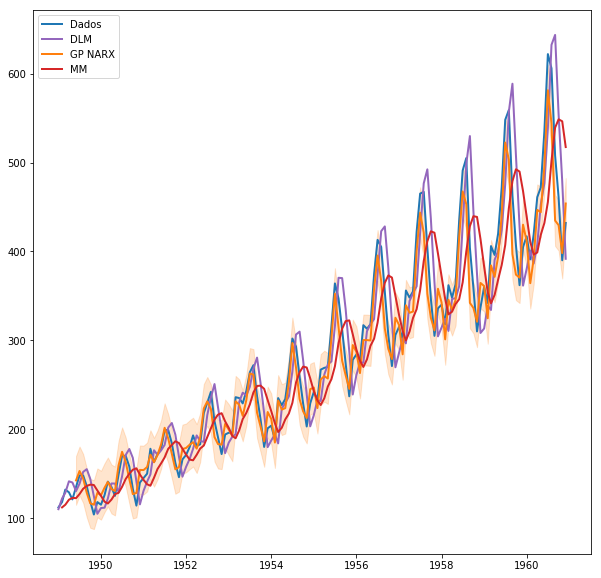

In [8]:
f,ax = plt.subplots(figsize=(10,10))
plot(ax, t, Y, label="Dados")
plot(ax, t, dlm_y, label= "DLM", color='C4')
plot(ax, t, *gp_y, label="GP NARX", color='C1')
plot(ax, t, mm, label="MM", color='C3')

# ax.set_xlim('1952','1960');

plt.legend()
plt.show()

In [9]:
sk.metrics.mean_squared_error(y_true=Y[48:], y_pred=dlm_y[48:])

2416.1272909931795

In [10]:
sk.metrics.mean_squared_error(y_true=Y[48:], y_pred=mm[48:])

4121.1283333333331

In [11]:
sk.metrics.mean_squared_error(y_true=Y[48:], y_pred=gp_y[0][48:])

620.73175352526903